In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
data = pd.read_csv("cardio_train.csv", delimiter = ";")

In [2]:
data.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
# Loading in the dataframes
heart_disease = pd.read_excel("heart_disease.xlsx")
intensive = pd.read_excel("cardiac_intensive.xlsx")
rehab = pd.read_excel("cardiac_rehab.xlsx")
cardio_physicians = pd.read_excel("cardio_disease.xlsx")
urban = pd.read_excel("urban_status.xlsx")

# Renaming the Value columns in the Dataframes
heart_disease = heart_disease.rename(columns={'Value': 'heart_disease_death_rate'})
intensive = intensive.rename(columns={'Value': 'intensive_care_units'})
rehab = rehab.rename(columns={'Value': 'rehabilitation_units'})
cardio_physicians = cardio_physicians.rename(columns={'Value': 'cardiac_physicians'})
urban = urban.rename(columns={'Value': 'urban_status'})

urban.head(5)

,County,State,urban_status
0,Milwaukee,WI,1
1,Alexandria,VA,1
2,Richmond City,VA,1
3,Norfolk,VA,1
4,Virginia Beach,VA,1


In [6]:
heart_disease = heart_disease.drop(columns=['Category Range'])
intensive = intensive.drop(columns=['Category Range'])
rehab = rehab.drop(columns=['Category Range'])
cardio_physicians = cardio_physicians.drop(columns=['Category Range'])


In [7]:
# Creating the final dataframe for data collected from the Interactive Atlas

merge1 = pd.merge(heart_disease, intensive, how='outer', on=['County', 'State'])
merge2 = pd.merge(merge1, rehab, how='outer', on=['County', 'State'])
merge3 = pd.merge(merge2, cardio_physicians, how='outer', on=['County', 'State'])
final_df = pd.merge(merge3, urban, how='outer', on=['County', 'State'])

# Adding NAs
final_df.replace("Insufficient Data", np.nan, inplace=True)
final_df

,County,State,heart_disease_death_rate,intensive_care_units,rehabilitation_units,cardiac_physicians,urban_status
0,Abbeville,SC,176,0.0,0.0,NaN,4.0
1,Acadia,LA,254.9,0.0,0.0,NaN,3.0
2,Accomack,VA,217.1,0.0,0.0,NaN,4.0
3,Ada,ID,137.4,2.0,2.0,21.9,3.0
4,Adair,IA,184.2,1.0,1.0,NaN,4.0
...,...,...,...,...,...,...,...
3222,Yuma,AZ,130.7,1.0,1.0,16.4,3.0
3223,Yuma,CO,113.6,1.0,1.0,NaN,4.0
3224,Zapata,TX,127.7,0.0,0.0,NaN,4.0
3225,Zavala,TX,239.5,0.0,0.0,NaN,4.0


In [9]:
final_df['heart_disease_death_rate'] = pd.to_numeric(final_df['heart_disease_death_rate'], errors='coerce')
final_df['means'] = final_df.groupby('State')['heart_disease_death_rate'].transform('mean')



# Convert 'cardiac_physicians' column to numeric
import pandas as pd

# Convert 'cardiac_physicians' column to numeric
final_df['cardiac_physicians'] = pd.to_numeric(final_df['cardiac_physicians'], errors='coerce')

# Calculate mean of 'cardiac_physicians' column grouped by 'State' and store in 'physicians' column
final_df['physicians'] = final_df.groupby('State')['cardiac_physicians'].transform('mean')





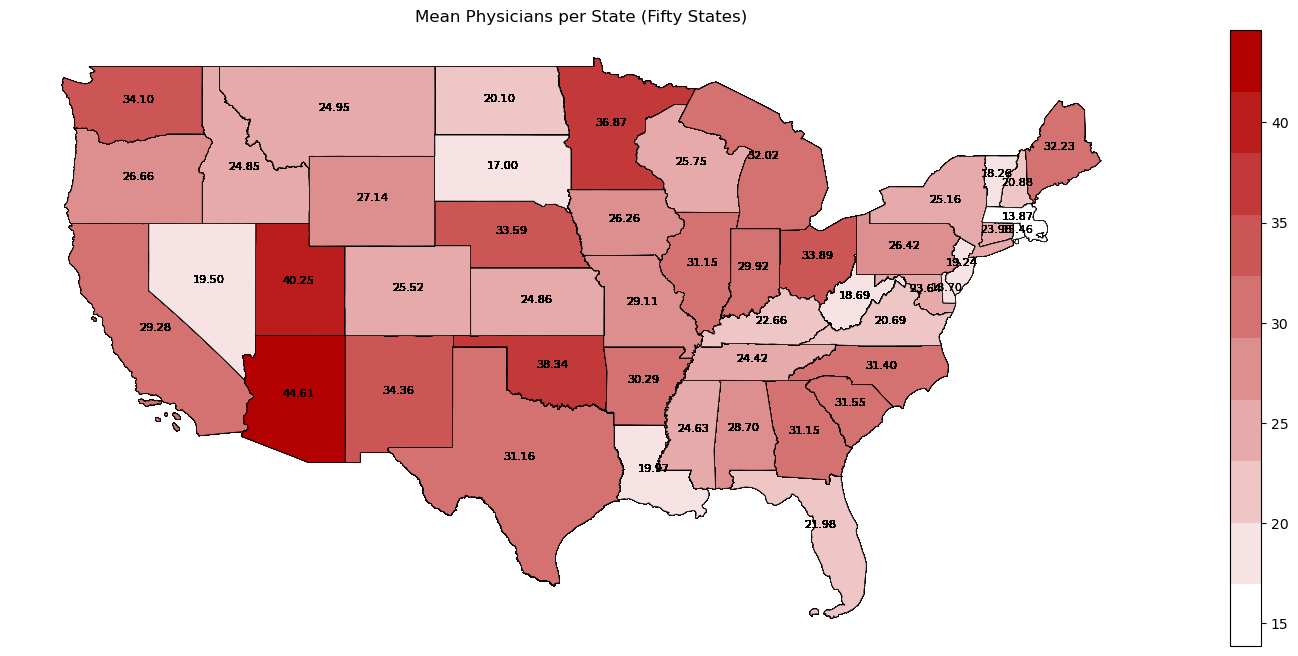

In [14]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap

# Load the shapefile containing state boundaries
states = gpd.read_file('map/tl_2023_us_state.shp')

# Convert the coordinate reference system (CRS) to EPSG:4326
states = states.to_crs("EPSG:4326")

# List of 50 states' abbreviations
fifty_states = [
    'AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]

# Filter out territories and other non-state regions
states = states[states['STUSPS'].isin(fifty_states)]

# Merge final_df data into states based on state abbreviation
states = states.merge(final_df, how='left', left_on='STUSPS', right_on='State')

# Define custom colormap
colors = [(1, 1, 1), (0.7, 0, 0)]  # White to Dark Red
cmap_name = 'custom_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)  # Adjust N for more/less color segments

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the map with merged data
states.plot(ax=ax, column='physicians', cmap=cm, edgecolor='black', linewidth=0.5, legend=True)

# Add the mean physicians value as text
for idx, row in states.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f'{row["physicians"]:.2f}', ha='center', fontsize=8)

# Customize plot settings
ax.set_title('Mean Physicians per State (Fifty States)')
ax.axis('off')

# Show the plot
plt.show()



In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler    
features = data.loc[:, data.columns != 'cardio']
target = data['cardio']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_model_1 = LogisticRegression(max_iter=1000)
logistic_model_1.fit(X_train_scaled, y_train)
predicted_1 = logistic_model_1.predict(X_test_scaled)
accuracy_model1 = accuracy_score(y_true=y_test, y_pred=predicted_1)

print(accuracy_model1)

0.7202857142857143


<Figure size 800x600 with 0 Axes>

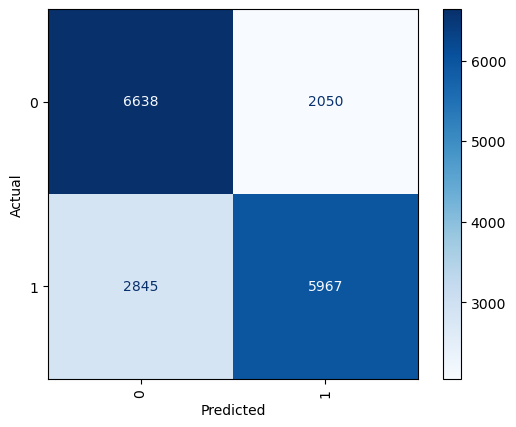

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix_1 = confusion_matrix(y_test, predicted_1)

cm_display_1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_1, display_labels=logistic_model_1.classes_)

plt.figure(figsize=(8, 6))
cm_display_1.plot(cmap='Blues', xticks_rotation='vertical')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [32]:
from sklearn.metrics import precision_score, recall_score

precision_1 = precision_score(y_test, predicted_1)
recall_1 = recall_score(y_test, predicted_1)


# Print precision and recall scores
print("Logistic Model 1:")
print("Precision:", precision_1)
print("Recall:", recall_1)

Logistic Model 1:
Precision: 0.7442933765747786
Recall: 0.6771448025419882
